<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Data-Growth" data-toc-modified-id="Data-Growth-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Growth</a></span></li><li><span><a href="#Hierarchical-Clustering" data-toc-modified-id="Hierarchical-Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hierarchical Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Normalize-to-reference-conditions" data-toc-modified-id="Normalize-to-reference-conditions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Normalize to reference conditions</a></span></li></ul></div>

<font size="4">This is a template notebook for exploratory analysis on your organism's QC'ed dataset.</font>

In [66]:
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [67]:
sns.set_style('ticks')

# Load data

In [68]:
org_dir = path.join('../data/interim/')
os.listdir(org_dir)

['ica_runs', 'log_tpm_qc.csv', 'metadata_qc.csv', 'primary_QC.csv']

In [69]:
DF_metadata = pd.read_csv(os.path.join(org_dir,'metadata_qc.csv'),index_col=0)
DF_log_tpm = pd.read_csv(os.path.join(org_dir,'log_tpm_qc.csv'),index_col=0)

# Data Growth

In [70]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata['ReleaseDate'])

In [71]:
first_date = min(DF_metadata['ReleaseDate'])
last_date = max(DF_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

Text(0, 0.5, 'Number of Samples')

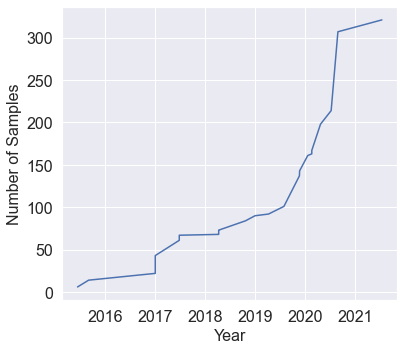

In [85]:
fig,ax = plt.subplots(figsize=(6,6))
growth = DF_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(ax=ax)
plt.xticks(date_range,date_range.strftime('%Y'),rotation=0,ha='center')
ax.tick_params(labelsize=16)
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Number of Samples',fontsize=16)

In [88]:
fig.savefig("data_growth.svg")

# Hierarchical Clustering

<font size=4> A clustermap is a great way to visualize the global correlations between one sample and all others. The following code uses hierarchical clustering to identify specific clusters in the clustermap <font size=4>
    
<font size=4> To increase the number of clusters, decrease the value of `thresh`. To decrease the number of clusters, increase the value of `thresh` <font size=4>

In [73]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches
# change this to get different number of clusters
thresh = .3

# retrieve clusters using fcluster 
corr = DF_log_tpm.corr()
corr.fillna(0,inplace=True)
dist = sch.distance.pdist(corr)
link = sch.linkage(dist, method='complete')
clst = pd.DataFrame(index=DF_log_tpm.columns)
clst['cluster'] = sch.fcluster(link, thresh * dist.max(), 'distance')

#get colors for each cluster
cm = plt.cm.get_cmap('tab20')
clr = dict(zip(clst.cluster.unique(), cm.colors))
clst['color'] = clst.cluster.map(clr)

print('Number of cluster: ', len(clr))

Number of cluster:  6


<font size="4">To view sample IDs in the clustermap, set `xticklabels` and `yticklabels` to `True`. You can increase the `size` variable to improve readability of sample IDs<font>

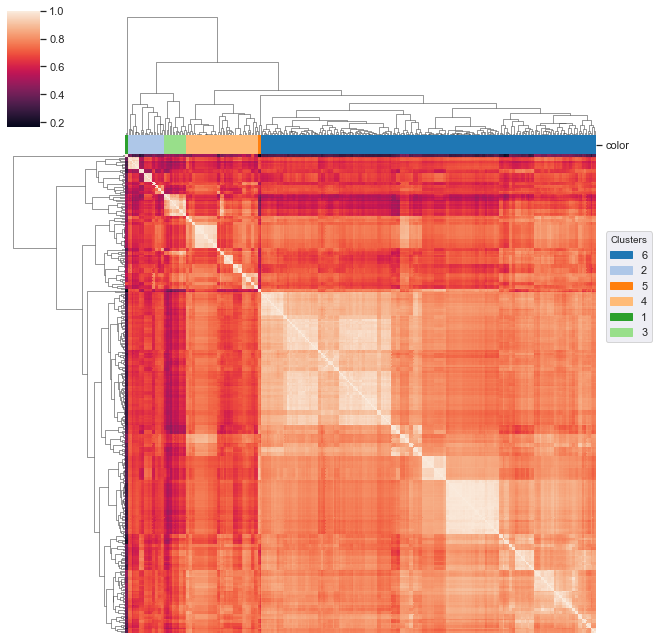

In [74]:
size = 9

legend_TN = [patches.Patch(color=c, label=l) for l,c in clr.items()]

sns.set(rc={'figure.facecolor':'white'})
g = sns.clustermap(DF_log_tpm.corr(), figsize=(size,size), 
                   row_linkage=link, col_linkage=link, col_colors=clst.color,
                  yticklabels=False, xticklabels=False)

l2=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1.01,0.85), handles=legend_TN,frameon=True)
l2.set_title(title='Clusters',prop={'size':10})

# PCA

In [75]:
from sklearn.decomposition import PCA
import numpy as np

<font size="4"> First compute principal components.</font>

In [76]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

<font size="4"> Next, plot the cumulative explained variance</font>

Number of dimensions for 99% of variance: 164


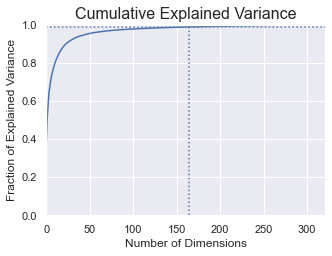

In [77]:
# Set the explained variance threshold
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance',fontsize=12)
ax.set_xlabel('Number of Dimensions',fontsize=12)
ax.set_title('Cumulative Explained Variance',fontsize=16)
print('Number of dimensions for 99% of variance:',dims)

<font size="4">Finally, plot the first two principle components. The following code colors data by Project Name.</font>

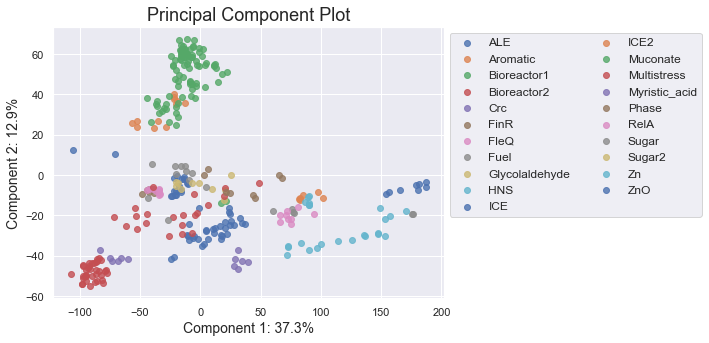

In [78]:
fig,ax = plt.subplots(figsize=(7,5))
for name,group in DF_metadata.groupby('project_name'):
    idx = DF_log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.8)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=14)
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=14)
ax.set_title('Principal Component Plot',fontsize=18)
plt.legend(bbox_to_anchor=(1,1),fontsize=12,ncol=2)

# Normalize to reference conditions

In [79]:
project_exprs = []
for name,group in DF_metadata.groupby('project_name'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    assert(len(ref_cond) == 1)
    ref_cond = ref_cond[0]
    
    # Ensure the reference condition is in fact in the project
    assert(ref_cond in group.condition_name.tolist())
    
    # Get reference condition sample ids
    ref_samples = group[group.condition_name == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

In [80]:
DF_log_tpm_norm.head()

,SRX8894563,SRX8894564,SRX8894565,SRX8894566,SRX8894567,SRX8894568,SRX8245718,SRX8245719,SRX8245720,SRX8245721,...,SRX7747535,SRX7747536,ERX1035001,ERX1035002,ERX1035005,ERX1035006,ERX1035007,ERX1035009,ERX1035010,ERX1035011
Geneid,,,,,,,,,,,,,,,,,,,,,
PP_0001,0.400852,0.388114,0.223650,0.353941,0.531170,0.374103,0.137303,0.003655,-0.131442,-0.009516,...,0.030728,-0.002360,0.078562,-0.078562,0.076979,0.124881,0.197734,0.054311,0.065038,0.213296
PP_0002,0.074183,-0.023530,0.247684,0.276216,0.186589,0.239253,-0.269922,-0.437214,0.319590,0.387547,...,0.002792,0.057819,0.012195,-0.012195,0.003095,0.017598,0.138033,-0.033052,-0.122785,0.213989
PP_0003,-0.183749,-0.200005,-0.059493,0.000937,0.046207,0.135945,-0.305466,-0.287017,0.173384,0.419099,...,-0.005824,-0.000979,0.100075,-0.100075,-0.068054,0.181256,0.248773,-0.124765,-0.006788,0.097695
PP_0004,0.275453,0.145446,0.468951,0.622281,0.583988,0.572905,-0.204918,-0.280389,0.143329,0.341977,...,0.016282,0.005181,0.057208,-0.057208,0.114066,0.205374,0.172893,0.005107,0.078710,0.135794
PP_0005,-0.834092,-0.933103,-1.250149,-1.338079,-1.380955,-1.292470,0.064047,0.413539,-0.150553,-0.327034,...,0.054121,0.017394,-0.041901,0.041901,0.126492,0.205114,0.042897,0.077276,0.064744,0.121682


<font size=4>Uncomment this code to save the log_tpm_norm file</font>

In [82]:
DF_log_tpm_norm.to_csv('../data/processed_data/log_tpm_norm.csv')